In [1]:
!pip -q install ultralytics roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 35.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 76.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/

In [2]:
import os
from pathlib import Path
from roboflow import Roboflow

rf = Roboflow(api_key="eh0g7YCvlOJ0KImhA3Rn")
project = rf.workspace("siriuscv").project("merged_tlogo-v3wlr")
version = project.version(1)
dataset = version.download("yolov11")
                
data_yaml = Path(dataset.location) / "data.yaml"
print("DATA.YAML:", data_yaml)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to merged_tlogo-1 in yolov11:: 100%|██████████| 16182/16182 [00:02<00:00, 7400.09it/s] 


DATA.YAML: /kaggle/working/merged_tlogo-1/data.yaml


In [3]:
import random, math

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

def list_images(dir_path):
    return [p for p in Path(dir_path).rglob("*") if p.suffix.lower() in IMG_EXTS]

def split_pos_neg(images_dir, labels_dir):
    pos, neg = [], []
    for img in list_images(images_dir):
        rel = img.relative_to(images_dir)
        lab = (labels_dir / rel).with_suffix(".txt")
        if lab.exists() and lab.stat().st_size > 0:
            pos.append(img)
        else:
            neg.append(img)
    return pos, neg

def downsample_train_to_ratio(
    images_dir, labels_dir, out_txt, target_pos_ratio=0.40, seed=0, shuffle=True
):
    pos, neg = split_pos_neg(images_dir, labels_dir)
    P, N = len(pos), len(neg)
    assert P > 0, "В train нет позитивов"

    # хотим (P) / (P + N_keep) ~= r  => N_keep = P*(1-r)/r
    r = float(target_pos_ratio)
    N_keep = int(round(P * (1 - r) / r))
    N_keep = min(N, max(0, N_keep))

    rng = random.Random(seed)
    neg_keep = rng.sample(neg, N_keep) if N_keep < N else neg

    merged = pos + neg_keep
    if shuffle:
        rng.shuffle(merged)

    out_txt = Path(out_txt)
    out_txt.parent.mkdir(parents=True, exist_ok=True)
    with out_txt.open("w") as f:
        for p in merged:
            f.write(str(p) + "\n")

    achieved = P / (P + len(neg_keep)) if (P + len(neg_keep)) else 0.0
    print(
        f"[train downsampled] pos={P}, neg_total={N}, neg_kept={len(neg_keep)}, "
        f"written={len(merged)}, achieved_ratio={achieved:.3f}"
    )
    return achieved

def write_plain_list(images_dir, out_txt, shuffle=False, seed=0):
    items = list_images(images_dir)
    if shuffle:
        rng = random.Random(seed); rng.shuffle(items)
    out_txt = Path(out_txt)
    with out_txt.open("w") as f:
        for p in items:
            f.write(str(p) + "\n")
    print(f"[list] {out_txt}  items={len(items)}")


In [16]:
BASE = Path("/kaggle/working/merged_tlogo-1")
ROOT = BASE
print("DATASET ROOT:", ROOT)

train_images = ROOT/"train/images"
train_labels = ROOT/"train/labels"

valid_dir = ROOT/"valid" if (ROOT/"valid").exists() else ROOT/"val"
val_images = valid_dir/"images"
val_labels = valid_dir/"labels"

test_images = ROOT/"test/images"
test_labels = ROOT/"test/labels"

for p in [train_images, train_labels, val_images, val_labels, test_images, test_labels]:
    print(p, "OK" if p.exists() else "MISSING")


DATASET ROOT: /kaggle/working/merged_tlogo-1
/kaggle/working/merged_tlogo-1/train/images OK
/kaggle/working/merged_tlogo-1/train/labels OK
/kaggle/working/merged_tlogo-1/valid/images OK
/kaggle/working/merged_tlogo-1/valid/labels OK
/kaggle/working/merged_tlogo-1/test/images OK
/kaggle/working/merged_tlogo-1/test/labels OK


In [5]:
BAL = BASE/"lists"
BAL.mkdir(exist_ok=True)

achieved = downsample_train_to_ratio(
    train_images, train_labels,
    out_txt=BAL/"train_balanced.txt",
    target_pos_ratio=0.45,
    seed=0, shuffle=True
)

write_plain_list(val_images,  BAL/"val.txt")
write_plain_list(test_images, BAL/"test.txt")

[train downsampled] pos=1176, neg_total=4485, neg_kept=1437, written=2613, achieved_ratio=0.450
[list] /kaggle/working/merged_tlogo-1/lists/val.txt  items=1617
[list] /kaggle/working/merged_tlogo-1/lists/test.txt  items=807


In [6]:
data_yaml = f"""
train: {BAL/'train_balanced.txt'}
val:   {BAL/'val.txt'}
test:  {BAL/'test.txt'}

nc: 1
names: ['tlogo']
"""
out = ROOT/"data_balanced.yaml"
out.write_text(data_yaml)
print("Wrote", out)

Wrote /kaggle/working/merged_tlogo-1/data_balanced.yaml


In [17]:
ROOT

PosixPath('/kaggle/working/merged_tlogo-1')

In [8]:
cfg_yaml = f"""
hsv_h: 0.0
hsv_s: 0.0
hsv_v: 0.0
bgr: 0.0

degrees: 10.0
translate: 0.05
scale: 0.5
shear: 0.0
perspective: 0.0

fliplr: 0.0
flipud: 0.0

mosaic: 1.0
close_mosaic: 15
mixup: 0.1
copy_paste: 0.0

auto_augment: none

"""

out = ROOT/"tlogo_augs.yaml"
open(out, "w").write(cfg_yaml)
print("Wrote", out)

Wrote /kaggle/working/merged_tlogo-1/tlogo_augs.yaml


In [9]:
from pathlib import Path


PREV_WEIGHTS = Path("/kaggle/input/yolo_last/pytorch/default/1/last.pt")

if not PREV_WEIGHTS.exists():
    PREV_WEIGHTS = None
    BASE_MODEL = "yolov11m.pt"
else:
    BASE_MODEL = None

print("Resuming from:", PREV_WEIGHTS if PREV_WEIGHTS else BASE_MODEL)


Resuming from: /kaggle/input/yolo_last/pytorch/default/1/last.pt


In [10]:
!pip -q install U ultralytics tensorboard plotly

from ultralytics import YOLO
from pathlib import Path
from ultralytics.utils import SETTINGS

ROOT = Path("/kaggle/working/merged_tlogo-1")
DATA = ROOT/"data_balanced.yaml"
AUGS = ROOT/"tlogo_augs.yaml"

print("DATA:", DATA)
print("AUGS:", AUGS)

SETTINGS.update({"tensorboard": True})

model = YOLO(PREV_WEIGHTS)

results = model.train(
    cfg=str(AUGS),
    data=str(DATA),
    epochs=120,
    patience=20,
    imgsz=960,
    batch=-1,
    device=0,
    rect=True,
    single_cls=True,
    amp=True,
    project=str(ROOT/"runs"),
    name="tlogo_y11m_bal_1",
    verbose=True,
    plots=True,
)
print("save_dir:", results.save_dir)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
DATA: /kaggle/working/merged_tlogo-1/data_balanced.yaml
AUGS: /kaggle/working/merged_tlogo-1/tlogo_augs.yaml
Ultralytics 8.3.201 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=none, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=/kaggle/working/merged_tlogo-1/tlogo_augs.yaml, classes=None, close_mosaic=15, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/merged_tlogo-1/data_balanced.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=120, erasing=0.4, exist_ok=

E0000 00:00:1758105574.217218      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758105574.322707      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorBoard: Start with 'tensorboard --logdir /kaggle/working/merged_tlogo-1/runs/tlogo_y11m_bal_1', view at http://localhost:6006/

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3

KeyboardInterrupt: 

In [18]:
from pathlib import Path
import os, shutil, time

IMGSZ   = globals().get("IMGSZ", 960)
DEVICE  = globals().get("DEVICE", 0)
data_yaml = Path(globals().get("data_yaml", "/kaggle/working/merged_tlogo-1/data.yaml"))

RUNS_DIR = Path("/kaggle/working/merged_tlogo-1/runs")
if "NAME" in globals():
    run_dir = RUNS_DIR / NAME
else:
    # Берём самый свежий ран
    candidates = sorted([p for p in RUNS_DIR.glob("*") if p.is_dir()],
                        key=lambda p: p.stat().st_mtime, reverse=True)
    assert candidates, "Не нашёл папку с ранaми в /kaggle/working/runs"
    run_dir = candidates[0]

weights_best = run_dir / "weights" / "best.pt"
weights_last = run_dir / "weights" / "last.pt"

print("Run dir:", run_dir)
print("BEST exists:", weights_best.exists(), weights_best)
print("LAST exists:", weights_last.exists(), weights_last)
print("DATA.YAML:", data_yaml)


Run dir: /kaggle/working/merged_tlogo-1/runs/tlogo_y11m_bal_1
BEST exists: True /kaggle/working/merged_tlogo-1/runs/tlogo_y11m_bal_1/weights/best.pt
LAST exists: True /kaggle/working/merged_tlogo-1/runs/tlogo_y11m_bal_1/weights/last.pt
DATA.YAML: 
train: /kaggle/working/merged_tlogo-1/lists/train_balanced.txt
val:   /kaggle/working/merged_tlogo-1/lists/val.txt
test:  /kaggle/working/merged_tlogo-1/lists/test.txt

nc: 1
names: ['tlogo']



In [14]:
ART_DIR = Path("/kaggle/working/artifacts")
ART_DIR.mkdir(parents=True, exist_ok=True)

to_copy = [
    weights_best, weights_last,
    run_dir / "results.csv",
    run_dir / "results.png",
    run_dir / "F1_curve.png",
    run_dir / "P_curve.png",
    run_dir / "R_curve.png",
    run_dir / "PR_curve.png",
    run_dir / "confusion_matrix.png",
]
for p in to_copy:
    if p.exists():
        shutil.copy2(p, ART_DIR / p.name)

# Упакуем всё в zip
ZIP_PATH = Path("/kaggle/working/artifacts_yolo.zip")
if ZIP_PATH.exists():
    ZIP_PATH.unlink()
shutil.make_archive(base_name=str(ZIP_PATH).replace(".zip",""), format="zip", root_dir=str(ART_DIR))

print("Saved artifacts to:", ART_DIR)
print("ZIP:", ZIP_PATH)
print("Files:", [f.name for f in ART_DIR.iterdir()])


Saved artifacts to: /kaggle/working/artifacts
ZIP: /kaggle/working/artifacts_yolo.zip
Files: ['best.pt', 'last.pt', 'results.csv']


In [21]:
from ultralytics import YOLO
import torch

assert weights_best.exists() or weights_last.exists(), "Нет весов для валидации."
ckpt_path = str(weights_best if weights_best.exists() else weights_last)
model = YOLO(ckpt_path)

VAL_NAME = "val_best"
val_dir = Path("/kaggle/working/val")
results = model.val(
    data=str(DATA),
    imgsz=IMGSZ,
    device=DEVICE,
    workers=2,
    save_json=False,   # включи True, если нужен COCO JSON
    plots=True,        # PR/F1/Confusion матрица
    project=str(val_dir),
    name=VAL_NAME,
    verbose=True
)

print("Val metrics:", results.results_dict)
print("Val dir:", val_dir / VAL_NAME)


Ultralytics 8.3.201 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 792.3±632.0 MB/s, size: 25.2 KB)
val: Scanning /kaggle/working/merged_tlogo-1/valid/labels.cache... 1617 images, 1286 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1617/1617 3.0Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 102/102 1.7it/s 1:010.5ss


invalid value encountered in less
invalid value encountered in less


                   all       1617        422      0.927      0.839      0.897      0.728
Speed: 0.4ms preprocess, 35.8ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /kaggle/working/val/val_best4
Val metrics: {'metrics/precision(B)': 0.9266854631348599, 'metrics/recall(B)': 0.8386641567005559, 'metrics/mAP50(B)': 0.8966394627243863, 'metrics/mAP50-95(B)': 0.7284740149290079, 'fitness': 0.7284740149290079}
Val dir: /kaggle/working/val/val_best


In [31]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

OLD_CSV = Path("/kaggle/input/configs/results_old.csv")  # твой файл с прошлым прогоном

# Находим последний ран (или используй NAME, если задавал ранее)
RUNS_DIR = Path("/kaggle/working/merged_tlogo-1/runs")
if "NAME" in globals():
    run_dir = RUNS_DIR / NAME
else:
    cand = sorted([p for p in RUNS_DIR.glob("*") if p.is_dir()],
                  key=lambda p: p.stat().st_mtime, reverse=True)
    assert cand, "Не нашёл /kaggle/working/runs/*"
    run_dir = cand[0]

NEW_CSV = run_dir / "results.csv"
assert OLD_CSV.exists(), f"Нет файла: {OLD_CSV}"
assert NEW_CSV.exists(), f"Нет файла: {NEW_CSV}"

df_old = pd.read_csv(OLD_CSV)
df_new = pd.read_csv(NEW_CSV)

# Страховка: приведём epoch к int, если есть
for df in (df_old, df_new):
    if "epoch" in df.columns:
        df["epoch"] = df["epoch"].astype(int)

# Сдвиг эпох для нового прогона, чтобы получить "глобальную" шкалу
offset = (df_old["epoch"].max() + 1) if "epoch" in df_old.columns else 0

df_old["epoch_global"] = df_old["epoch"] if "epoch" in df_old.columns else range(len(df_old))
df_new["epoch_global"] = (df_new["epoch"] + offset) if "epoch" in df_new.columns else range(offset, offset + len(df_new))

df_old["phase"] = "old"
df_new["phase"] = "new"

# Совмещаем без сортировки колонок, чтобы сохранить знакомый порядок
df_merged = pd.concat([df_old, df_new], axis=0, ignore_index=True, sort=False)

OUT_CSV = Path("/kaggle/working/results_merged.csv")
df_merged.to_csv(OUT_CSV, index=False)
print("Merged CSV saved to:", OUT_CSV)
print("Columns:", list(df_merged.columns))
print("Rows:", len(df_merged))


Merged CSV saved to: /kaggle/working/results_merged.csv
Columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2', 'epoch_global', 'phase']
Rows: 53


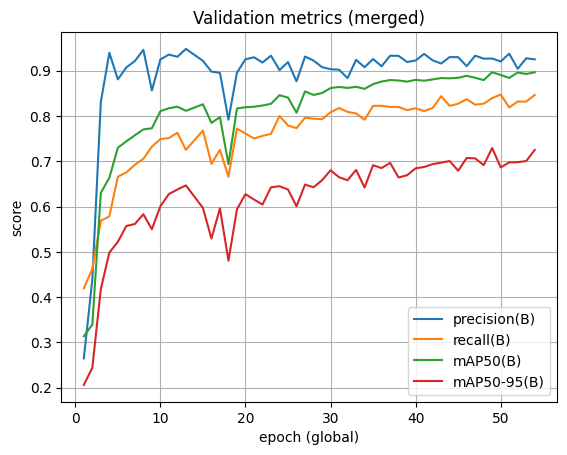

Saved: /kaggle/working/results_merged_metrics.png


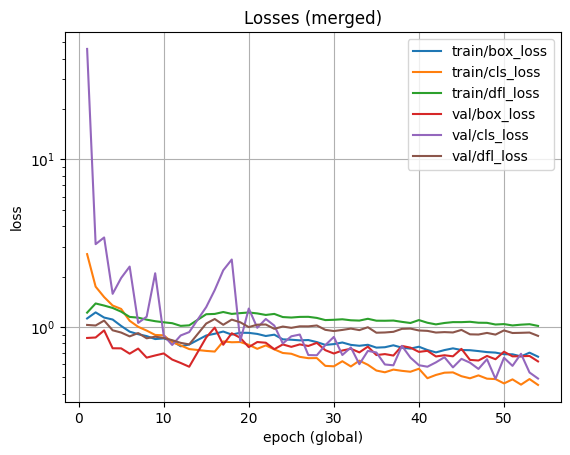

Saved: /kaggle/working/results_merged_losses.png
Нет speed/* колонок для графика.


In [42]:
import matplotlib.pyplot as plt

# какие столбцы будем рисовать (проверяем наличие)
metrics_candidates = [
    "metrics/precision(B)", "metrics/recall(B)", "metrics/mAP50(B)", "metrics/mAP50-95(B)"
]
loss_candidates = [
    "train/box_loss", "train/cls_loss", "train/dfl_loss",
    "val/box_loss", "val/cls_loss", "val/dfl_loss"
]
speed_candidates = [c for c in df_merged.columns if c.startswith("speed/")]

metrics_cols = [c for c in metrics_candidates if c in df_merged.columns]
loss_cols = [c for c in loss_candidates if c in df_merged.columns]

# --- Метрики ---
if metrics_cols:
    plt.figure()
    for col in metrics_cols:
        plt.plot(df_merged["epoch_global"], df_merged[col], label=col.split("/")[-1])
    plt.xlabel("epoch (global)")
    plt.ylabel("score")
    plt.title("Validation metrics (merged)")
    plt.legend()
    plt.grid(True)
    METRICS_PNG = "/kaggle/working/results_merged_metrics.png"
    plt.savefig(METRICS_PNG, bbox_inches="tight", dpi=150)
    plt.show()
    print("Saved:", METRICS_PNG)
else:
    print("Нет метрик для графика (metrics/*).")

# --- Лоссы ---
if loss_cols:
    plt.figure()
    for col in loss_cols:
        plt.plot(df_merged["epoch_global"], df_merged[col], label=col)
    plt.xlabel("epoch (global)")
    plt.ylabel("loss")
    plt.title("Losses (merged)")
    plt.legend()
    plt.yscale('log')
    plt.grid(True)
    LOSSES_PNG = "/kaggle/working/results_merged_losses.png"
    plt.savefig(LOSSES_PNG, bbox_inches="tight", dpi=150)
    plt.show()
    print("Saved:", LOSSES_PNG)
else:
    print("Нет лоссов для графика (*_loss).")

# --- Скорость (опционально) ---
if speed_candidates:
    plt.figure()
    for col in speed_candidates:
        plt.plot(df_merged["epoch_global"], df_merged[col], label=col.split("/")[-1])
    plt.xlabel("epoch (global)")
    plt.ylabel("ms")
    plt.title("Speed per epoch (merged)")
    plt.legend()
    plt.grid(True)
    SPEED_PNG = "/kaggle/working/results_merged_speed.png"
    plt.savefig(SPEED_PNG, bbox_inches="tight", dpi=150)
    plt.show()
    print("Saved:", SPEED_PNG)
else:
    print("Нет speed/* колонок для графика.")


In [33]:
from glob import glob

# Попробуем найти валидационные изображения разных расположений:
val_globs = [
"/kaggle/working/merged_tlogo-1/valid/images/*"
]
val_imgs = []
for pat in val_globs:
    val_imgs.extend(glob(str(Path(data_yaml).parent / pat)))
val_imgs = sorted(list(set(val_imgs)))[:16]  # до 16 картинок

if val_imgs:
    out = model.predict(
        val_imgs,
        imgsz=IMGSZ,
        device=DEVICE,
        conf=0.25,
        iou=0.7,
        save=True,
        project="/kaggle/working/preds",
        name="val_preview"
    )
    print("Saved predictions to /kaggle/working/preds/val_preview")
else:
    print("Не нашёл валидационные изображения — пропускаю превью.")



0: 960x960 (no detections), 52.3ms
1: 960x960 1 item, 52.3ms
2: 960x960 1 item, 52.3ms
3: 960x960 1 item, 52.3ms
4: 960x960 1 item, 52.3ms
5: 960x960 2 items, 52.3ms
6: 960x960 3 items, 52.3ms
7: 960x960 2 items, 52.3ms
8: 960x960 2 items, 52.3ms
9: 960x960 2 items, 52.3ms
10: 960x960 1 item, 52.3ms
11: 960x960 1 item, 52.3ms
12: 960x960 1 item, 52.3ms
13: 960x960 (no detections), 52.3ms
14: 960x960 1 item, 52.3ms
15: 960x960 (no detections), 52.3ms
Speed: 5.2ms preprocess, 52.3ms inference, 0.7ms postprocess per image at shape (1, 3, 960, 960)
Results saved to /kaggle/working/preds/val_preview2
Saved predictions to /kaggle/working/preds/val_preview


In [34]:
import os, zipfile
from pathlib import Path

def zip_folder(src_dir, zip_path):
    """
    Упаковывает содержимое папки src_dir в zip_path.
    Пример:
      zip_folder("/kaggle/working/artifacts", "/kaggle/working/artifacts_yolo.zip")
    """
    src_dir = Path(src_dir)
    zip_path = Path(zip_path)
    assert src_dir.is_dir(), f"Источник не папка: {src_dir}"
    zip_path.parent.mkdir(parents=True, exist_ok=True)
    # гарантируем расширение .zip
    if zip_path.suffix.lower() != ".zip":
        zip_path = zip_path.with_suffix(".zip")
    with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
        for root, _, files in os.walk(src_dir):
            for f in files:
                full = Path(root) / f
                # относительный путь внутри архива (без абсолютных префиксов)
                rel = full.relative_to(src_dir)
                zf.write(full, rel)
    return zip_path

zip_path = zip_folder("/kaggle/working/preds/val_preview2", "/kaggle/working/preds/val_preview2.zip")
print("ZIP saved to:", zip_path)


ZIP saved to: /kaggle/working/preds/val_preview2.zip


In [39]:
ckpt = Path("/kaggle/working/merged_tlogo-1/runs/tlogo_y11m_bal_1/weights/best.pt")
TEST_NAME = "test_metrics"
TEST_DIR = Path("/kaggle/working/test")
model = YOLO(str(ckpt))
res_test = model.val(
    data=str(DATA),
    split="test",
    imgsz=IMGSZ,
    device=DEVICE,
    workers=2,
    plots=True,
    project=str(TEST_DIR),
    name=TEST_NAME,
    verbose=True
)
print("Test metrics:", res_test.results_dict)


Ultralytics 8.3.201 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1449.0±951.7 MB/s, size: 66.6 KB)
val: Scanning /kaggle/working/merged_tlogo-1/test/labels... 807 images, 621 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 807/807 1.9Kit/s 0.4s0.0ss
val: New cache created: /kaggle/working/merged_tlogo-1/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 51/51 1.7it/s 30.6s0.7ss


invalid value encountered in less
invalid value encountered in less


                   all        807        234      0.948      0.876      0.936      0.755
Speed: 0.4ms preprocess, 36.0ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /kaggle/working/test/test_metrics
Test metrics: {'metrics/precision(B)': 0.9477358889177816, 'metrics/recall(B)': 0.8760683760683761, 'metrics/mAP50(B)': 0.9357161696152162, 'metrics/mAP50-95(B)': 0.7545396198171855, 'fitness': 0.7545396198171855}


In [40]:
zip_path = zip_folder("/kaggle/working/test/test_metrics", "/kaggle/working/test/test_metrics.zip")
